# Hub analysis
In this notebook, we'll use networkx to examine hubs and connectivity in the overall citation network and how it relates the the classification identity of the nodes involved in given neighborhoods.

In [1]:
import networkx as nx
import pandas as pd
from collections import defaultdict
import seaborn as sns

## Reading in graph data

In [2]:
graph = nx.read_graphml('../data/citation_network/full_10000_with_classification_19Sep2023.graphml')

## Analysis
Our hypothesis is that there is a higher degree of connectivity between nodes of the same class (study system). To test this hypothesis in a naive way, we can find the hubs in the dataset, and then demonstarte that there is a higher proportion of nodes connected to a given hub that match the classification of the hub, as opposed to being of the First, we want to find hubs in the network, which we can do by calculating degree centrality.

#### NOTE
I think that 30% `NOCLASS` is way too high. Am currently working on a method for reducing this proportion; for now, will exclude any hub neighborhoos that has more than 10% NOCLASS nodes.

In [3]:
dcs = pd.Series(nx.degree_centrality(graph)).sort_values(ascending=False)
dcs

bcdc1cde06d5c20aff70be5635870ee1f9d9fe10    0.005579
7ad7bfea046b027a57eeccb2013a69dbaffc5bdb    0.005512
8545e17cd9f76662b713b93a2591635846e1b1d7    0.005195
913ec33d0d1c47b1d852f561f445ab3891370c69    0.005195
228d753d84f2132bfdaa93cadffd887358694ad4    0.004769
                                              ...   
83ce792f42fbadc1a4713b9f2d4ec365632d3593    0.000000
63aeea8dd163907d3c2c4b1c8b90b4a950910664    0.000000
226f7d0e79bbd72aa7591a14c59f92a2aa976b9a    0.000000
31c2ec5fc939936b58c217d3869e027363146ea3    0.000000
5620bd85d2627d79044a32d0a081b022dd6fd2f6    0.000000
Length: 192505, dtype: float64

We can visualize how skewed our dataset is by making a histogram of degree centrality:

<Axes: xlabel='Degree Centrality', ylabel='Frequency'>

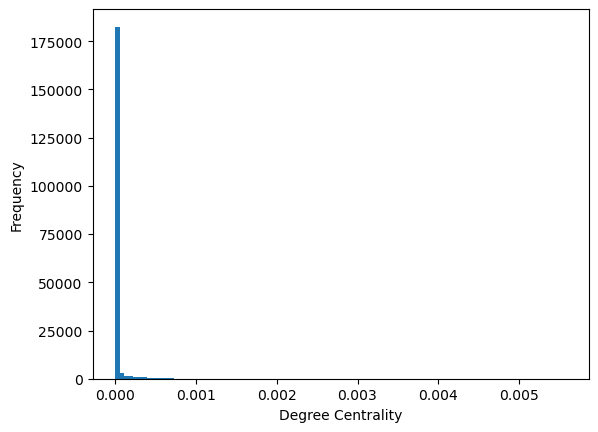

In [4]:
dcs.plot.hist(bins=100, xlabel='Degree Centrality')

This histogram is quite hard to read because of how skewed they are; let's make a violin plot instead.

<Axes: >

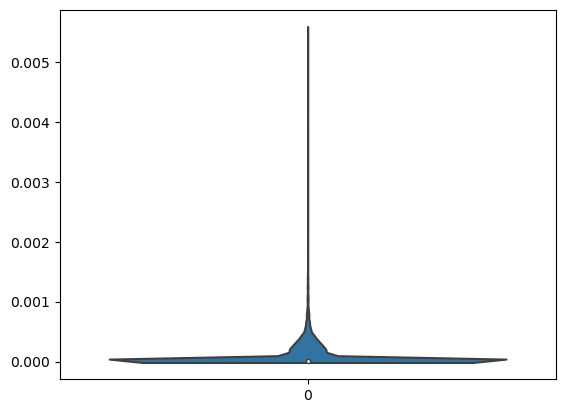

In [5]:
sns.violinplot(dcs)

These plots show that there are only a few highly connected nodes, and that most other nodes have very few connections. This intuitively makes sense; only a few papers are highly cited.

Now, let's take the top 1% of nodes by degree centrality:

In [6]:
# dcs_top = dcs.nlargest(int(0.01*len(dcs)))
# dcs_top

We now want to examine what proportion of the neighbors of each highly connected node are of the same study system as the hub node:

#### NOTE:
In a directed graph, incoming edges to a node count for the degree/degree centrality of that node, but the nodes form which those edges come are not counted as neighbors. Since I am interested in both directions of neighbors for a given node, I'm going to make this an undirected graph for the following calculations.

In [7]:
graph_un = graph.to_undirected()

In [8]:
# Get the IDs of the neighbor nodes
neighbors_id_dict = {i: list(graph_un.neighbors(i)) for i in dcs.index}

In [9]:
# Get the study system for each node
study_sys_attrs = nx.get_node_attributes(graph_un, 'study_system')
study_system_dict = {k: [study_sys_attrs[i] for i in v] for k, v in neighbors_id_dict.items()}

In [16]:
len(study_system_dict)

192505

In [23]:
prop_noclass = {k: v.count('NOCLASS')/len(v) for k, v in study_system_dict.items() if len(v) > 0}
len([k for k, v in prop_noclass.items() if (v < 0.1) and (study_sys_attrs[k] != 'NOCLASS')])

102292

In [36]:
same_prop = {}
for nid, study_list in study_system_dict.items():
    if study_list.count('NOCLASS') < 0.1*len(study_list):
        if study_sys_attrs[nid] != 'NOCLASS':
            prop_same = study_list.count(study_sys_attrs[nid])/len(study_list)
            same_prop[nid] = prop_same
len(same_prop)

102292

In [37]:
same_prop_by_type = []
for k, v in same_prop.items():
    same_prop_by_type.append([study_sys_attrs[k], v])
same_prop_df = pd.DataFrame(same_prop_by_type, columns=['class', 'prop_same'])
same_prop_df.head()

,class,prop_same
0,Animal,0.893000
1,Plant,0.878187
2,Microbe,0.883978
3,Plant,0.937255
4,Plant,0.844444


In [40]:
same_prop_df.groupby('class').count()

,prop_same
class,
Animal,21731
Fungi,4491
Microbe,19359
Plant,56711


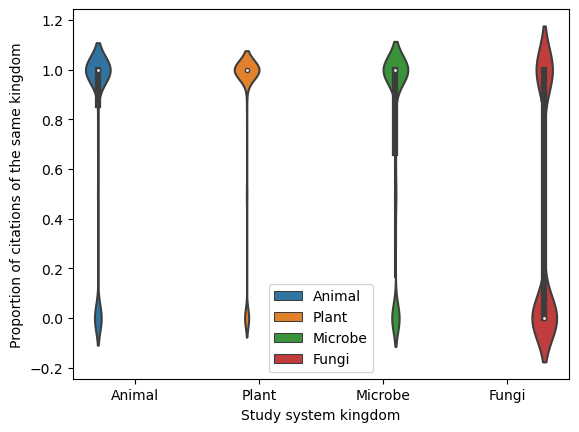

In [39]:
ax = sns.violinplot(data=same_prop_df, x='class', y='prop_same', hue='class')
ax.set(xlabel='Study system kingdom', ylabel='Proportion of citations of the same kingdom')
ax.legend()

The above analysis asks, "How many connections are to papers of the same kingdom?" Alternatively, we can ask, "How many of a paper's citations are of papers of the same kingdom?" To do this, we use the directed graph, and choose top nodes based on number of neighbors:

In [42]:
# Get the IDs of the neighbor nodes
neighbors = pd.Series({n: len([n for n in graph.neighbors(n)]) for n in graph.nodes}).sort_values(ascending=False)
# Get the study system for each node
study_sys_attrs = nx.get_node_attributes(graph, 'study_system')
neighbor_idents = {i: [study_sys_attrs[n] for n in graph.neighbors(i)] for i in neighbors.index}

In [44]:
len(neighbor_idents)

192505

In [43]:
same_prop = {}
for nid, study_list in neighbor_idents.items():
    if study_list.count('NOCLASS') < 0.1*len(study_list):
        if study_sys_attrs[nid] != 'NOCLASS':
            prop_same = study_list.count(study_sys_attrs[nid])/len(study_list)
            same_prop[nid] = prop_same
len(same_prop)

1018

In [45]:
# Get the proportion that is the same
same_prop_by_type = []
for k, v in same_prop.items():
    same_prop_by_type.append([study_sys_attrs[k], v])
same_prop_df = pd.DataFrame(same_prop_by_type, columns=['class', 'prop_same'])
same_prop_df.head()

,class,prop_same
0,Animal,0.893000
1,Microbe,0.898785
2,Microbe,0.866109
3,Plant,0.871795
4,Microbe,0.904977


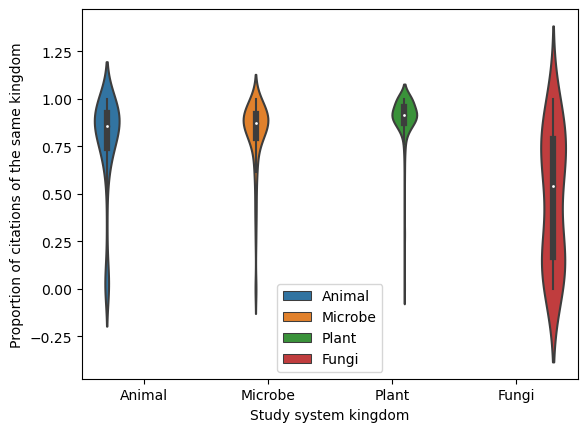

In [46]:
ax = sns.violinplot(data=same_prop_df, x='class', y='prop_same', hue='class')
ax.set(xlabel='Study system kingdom', ylabel='Proportion of citations of the same kingdom')
ax.legend()